# Classification

TODO: riguardare i testi indicati con il tag TEMP<br>
TODO: rimuovere i testi con il tag REM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
df_players_complete = pd.read_csv("./datasets/players.csv", index_col=0)

## Features choice

In [4]:
# per il momento, gli stessi attributi utilizzati per il clustering REM
# problema: la feature mean_rank_points, da utilizzare come label, era già presente tra le features utilizzate per il clustering
df_players = df_players_complete[['max_tourney_revenue', 'lrpOnMxrp', 'matches_won_ratio', 'mean_rank_points']]

## Label computation

In [5]:
df_players['is_high_ranked'] = np.digitize(df_players['mean_rank_points'], bins=[df_players['mean_rank_points'].median()])

C:\Users\Domenico\AppData\Local\Temp/ipykernel_772/3187907699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['is_high_ranked'] = np.digitize(df_players['mean_rank_points'], bins=[df_players['mean_rank_points'].median()])


In [6]:
df_players[['mean_rank_points', 'is_high_ranked']]

,mean_rank_points,is_high_ranked
14,98.828025,1
22,6.062500,0
29,103.492063,1
36,116.318182,1
43,386.323383,1
...,...,...
10083,27.897059,0
10086,3.000000,0
10091,9.648148,0
10092,74.174419,1


In [7]:
df_players = df_players.drop(columns=['mean_rank_points'])
df_players

,max_tourney_revenue,lrpOnMxrp,matches_won_ratio,is_high_ranked
14,2876086.35,0.837321,0.477707,1
22,1460820.61,0.333333,0.500000,0
29,1012331.80,0.530387,0.587302,1
36,888975.70,0.193750,0.260870,1
43,3761778.69,0.128655,0.542289,1
...,...,...,...,...
10083,2484975.25,0.878049,0.447368,0
10086,1073007.12,1.000000,0.038462,0
10091,1436125.64,1.000000,0.410256,0
10092,1804103.26,0.981481,0.546512,1


## Preprocessing

In [8]:
df_players_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_players), columns=df_players.columns)
df_players_norm

X = df_players_norm.drop(columns=['is_high_ranked'])
Y = df_players_norm['is_high_ranked']
train_set, test_set, train_label, test_label = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=0)

## Classification

TODO: REM da questo punto in poi si tratta di copia e incolla adattati (dal progetto di Pasquali ecc.)

### Decision Tree

In [9]:
from sklearn import tree

In [20]:
parameters = {'criterion':['gini','entropy'],'max_depth':[2, 3, 4]}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5)
clf.fit(train_set, train_label)
pd.DataFrame(clf.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending = False)

#TODO: REM clf.best_score_, clf.best_params_

,params,mean_test_score
5,"{'criterion': 'entropy', 'max_depth': 4}",0.855504
2,"{'criterion': 'gini', 'max_depth': 4}",0.849300
3,"{'criterion': 'entropy', 'max_depth': 2}",0.845967
4,"{'criterion': 'entropy', 'max_depth': 3}",0.845018
0,"{'criterion': 'gini', 'max_depth': 2}",0.845012
1,"{'criterion': 'gini', 'max_depth': 3}",0.844535


In [21]:
dt = tree.DecisionTreeClassifier(criterion=clf.best_params_['criterion'], splitter='best', 
                                  max_depth=clf.best_params_['max_depth'], 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

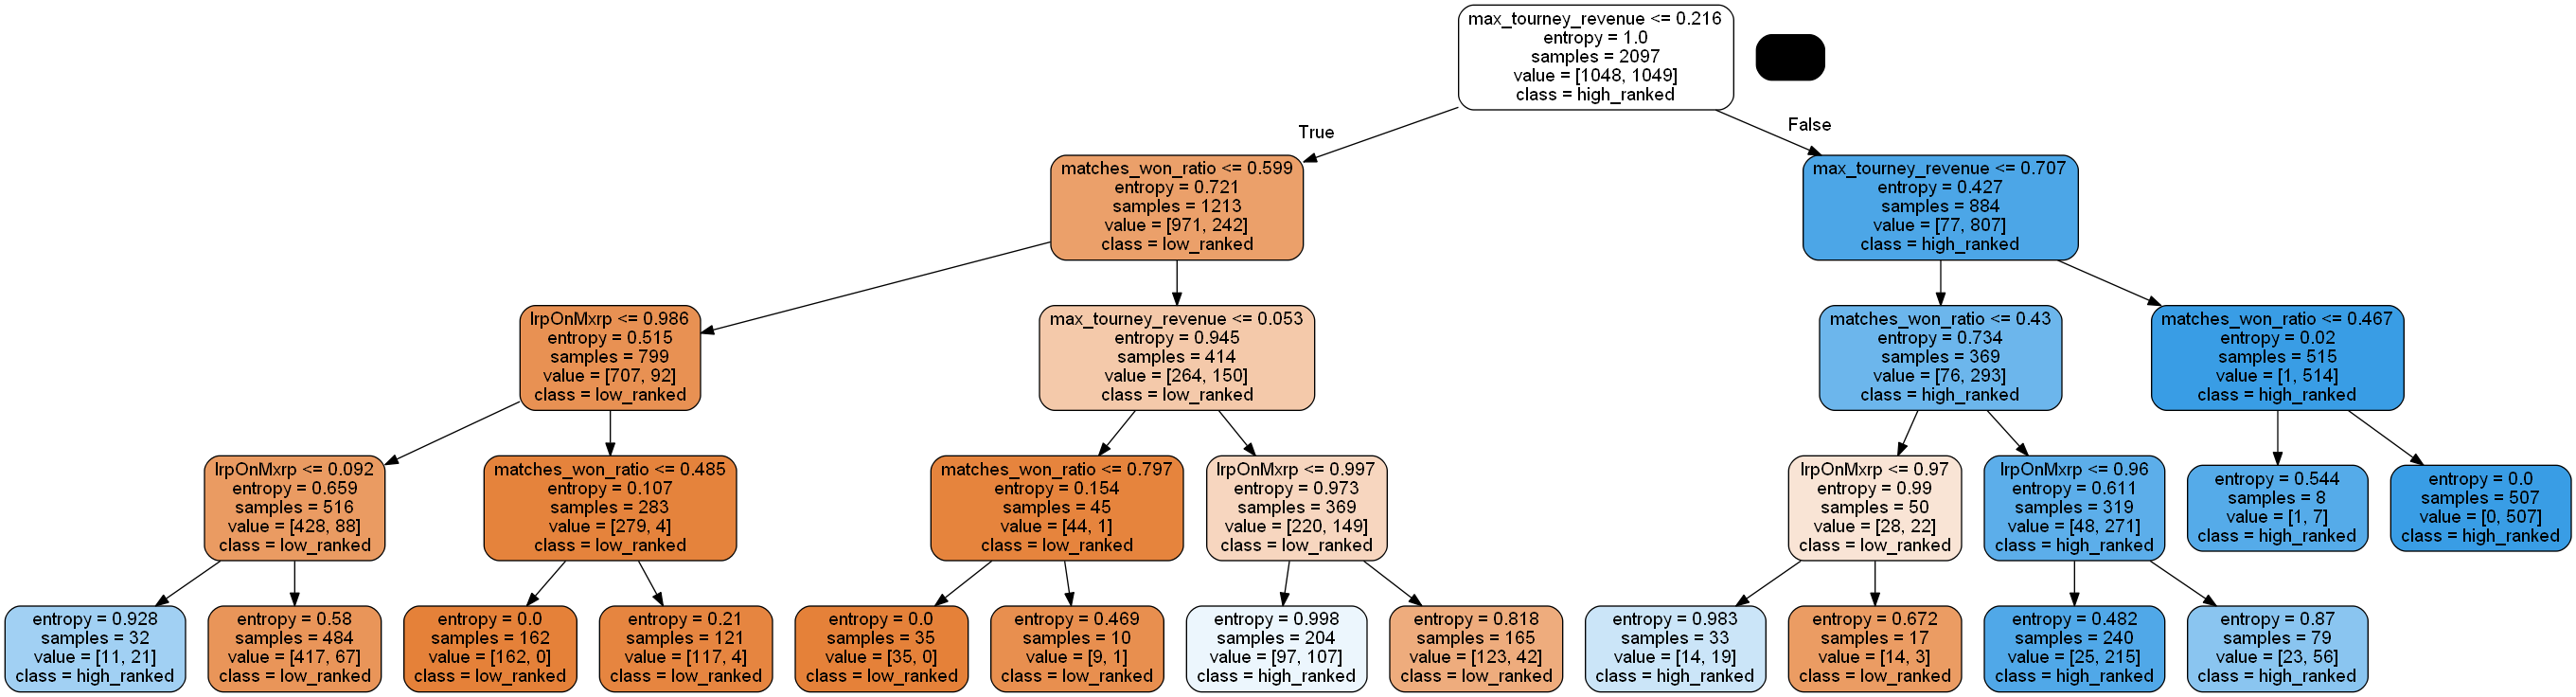

In [22]:
from IPython.display import Image 
import pydotplus

classes = ['low_ranked', 'high_ranked']
dot_data = tree.export_graphviz(dt, out_file=None,
                         feature_names=list(train_set.columns),
                         class_names=classes,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#TODO: problema, cos'è il rettangolo nero?

In [23]:


# predict and evaluate results on training and test set
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

print('Accuracy training set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision training set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall training set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score trainig set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support training set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy training set  0.8626609442060086
Accuracy test set  0.8422222222222222
Precision training set  0.8636221157308953
Recall training set  0.8626609442060086
F1 score trainig set  0.8625681218682912
Support training set  (array([0.88229376, 0.84496827]), array([0.83683206, 0.8884652 ]), array([0.8589618, 0.866171 ]), array([1048, 1049], dtype=int64))


In [ ]:
import plotly.figure_factory as ff

x = classes[::-1] 
y = classes

cm = confusion_matrix(test_label, test_pred_dt, labels=dt.classes_)
fig = ff.create_annotated_heatmap(cm[[1, 0]], x=x, y=y, colorscale='Viridis')

# add title
fig.update_layout(
                  xaxis = dict(title='Predicted value'),
                  yaxis = dict(title='Real value')
                 )

fig['data'][0]['showscale'] = True
fig.show()


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# pretty printing of metrics computed on test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes, zero_division=0)) 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

 high_ranked       0.83      0.88      0.85       450
  low_ranked       0.87      0.82      0.84       450

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900

